In [1]:
import numpy as np
import matplotlib.pyplot as plt

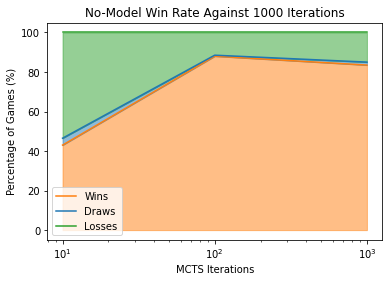

In [85]:
data = np.genfromtxt("build/MCTS_win_rate_data.csv", delimiter=",", skip_header=1)

x = np.unique(data[:, 1])
y_losses = np.array([np.sum(data[(data[:, 1] == v), 3] == 1) for v in x])
y_draws = np.array([np.sum(data[(data[:, 1] == v), 3] == 2) for v in x])
y_wins = np.array([np.sum(data[(data[:, 1] == v), 3] == 0) for v in x])

# Convert to percentages
total_games = y_wins + y_draws + y_losses
y_wins_pct = y_wins / total_games * 100
y_draws_pct = y_draws / total_games * 100
y_losses_pct = y_losses / total_games * 100

plt.plot(x, y_wins_pct, color="tab:orange", label="Wins")
plt.fill_between(x, y_wins_pct, 0, color='tab:orange', alpha=0.5)

plt.plot(x, y_wins_pct + y_draws_pct, color="tab:blue", label="Draws")
plt.fill_between(x, y_wins_pct + y_draws_pct, y_wins_pct, color='tab:blue', alpha=0.5)

plt.plot(x, y_wins_pct + y_draws_pct + y_losses_pct, color="tab:green", label="Losses")
plt.fill_between(x, y_wins_pct + y_draws_pct + y_losses_pct, y_wins_pct + y_draws_pct, color='tab:green', alpha=0.5)

plt.title("No-Model Win Rate Against 1000 Iterations")
plt.legend()
plt.xlabel("MCTS Iterations")
plt.ylabel("Percentage of Games (%)")
plt.xscale('log')  # Set x-axis to logarithmic scale

In [11]:
np.sum(data[(data[:, 1] == 500), 3] == 1)

np.int64(453)

In [12]:
p1_wins = np.sum(data[:, 3] == 0)
p2_wins = np.sum(data[:, 3] == 1)
draws = np.sum(data[:, 3] == 2)

print(f"Player 1 wins {p1_wins} ({p1_wins / data.shape[0]})\nPlayer 2 wins {p2_wins} ({p2_wins / data.shape[0]})\nDraws         {draws} ({draws / data.shape[0]})")

Player 1 wins 708 (0.708)
Player 2 wins 139 (0.139)
Draws         153 (0.153)


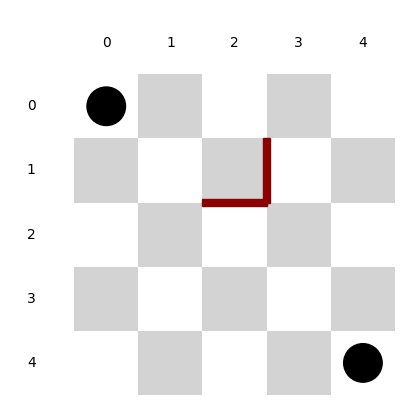

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Board size
board_size = 5

# Pawn positions (row, col), with (0,0) at top-left now
pawn1_pos = (0, 0)
pawn2_pos = (4, 4)

# Fences: (row, col, orientation) with same top-left origin
fences = [
    (2, 2, 'h'),
    (1, 3, 'v')
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-1, board_size)
ax.set_ylim(board_size, -1)  # Invert y-axis
ax.set_aspect('equal')
ax.axis('off')

# Draw the checkerboard
for row in range(board_size):
    for col in range(board_size):
        color = 'lightgrey' if (row + col) % 2 else 'white'
        square = patches.Rectangle((col, row), 1, 1, facecolor=color)
        ax.add_patch(square)

# Draw pawns
def draw_pawn(position, color='black'):
    row, col = position
    circle = patches.Circle((col + 0.5, row + 0.5), 0.3, color=color)
    ax.add_patch(circle)

draw_pawn(pawn1_pos)
draw_pawn(pawn2_pos)

# Draw fences
def draw_fence(row, col, orientation, color='darkred'):
    if orientation == 'h':
        # Horizontal fence between (col, row) and (col+1, row)
        x = col
        y = row
        fence = patches.Rectangle((x, y - 0.05), 1, 0.1, color=color)
    elif orientation == 'v':
        # Vertical fence between (col, row) and (col, row+1)
        x = col
        y = row
        fence = patches.Rectangle((x - 0.05, y), 0.1, 1, color=color)
    ax.add_patch(fence)

for row, col, orientation in fences:
    draw_fence(row, col, orientation)

# Top column labels
for col in range(board_size):
    ax.text(col + 0.5, -0.6, str(col), ha='center', va='top', fontsize=10)

# Left row labels
for row in range(board_size):
    ax.text(-0.6, row + 0.5, str(row), ha='right', va='center', fontsize=10)

plt.show()


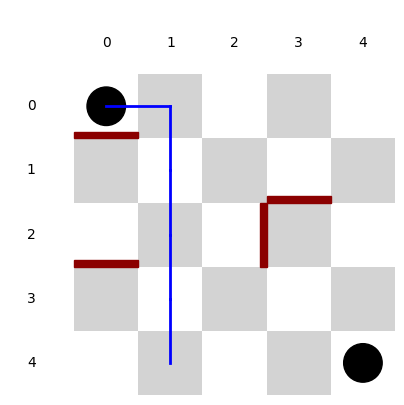

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, deque

board_size = 5

pawn1_pos = (0, 0)
pawn2_pos = (4, 4)

fences = [
    (2, 2, 'h'),
    (1, 3, 'v'),
    (2, 0, 'v'),
    (0, 0, 'v')
]

# Step 1: Build graph
graph = defaultdict(list)

for row in range(board_size):
    for col in range(board_size):
        node = (row, col)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = row + dr, col + dc
            if 0 <= nr < board_size and 0 <= nc < board_size:
                graph[node].append((nr, nc))

def remove_edge(a, b):
    if b in graph[a]: graph[a].remove(b)
    if a in graph[b]: graph[b].remove(a)

for row, col, orientation in fences:
    if orientation == 'h':
        a = (row, col)
        b = (row, col + 1)
    elif orientation == 'v':
        a = (row, col)
        b = (row + 1, col)
    remove_edge(a, b)

# Step 2: BFS to get path
def bfs_path(start):
    visited = {}
    queue = deque([(start, [])])

    while queue:
        current, path = queue.popleft()
        if current[0] == board_size - 1:
            return path + [current]
        if current in visited:
            continue
        visited[current] = True
        for neighbor in graph[current]:
            if neighbor not in visited:
                queue.append((neighbor, path + [current]))
    return []

# Get paths
path1 = bfs_path(pawn1_pos)
path2 = bfs_path(pawn2_pos)

# Step 3: Draw board
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-1, board_size)
ax.set_ylim(board_size, -1)
ax.set_aspect('equal')
ax.axis('off')

# Draw squares
for row in range(board_size):
    for col in range(board_size):
        color = 'lightgrey' if (row + col) % 2 else 'white'
        rect = patches.Rectangle((col, row), 1, 1, facecolor=color)
        ax.add_patch(rect)

# Draw pawns
def draw_pawn(pos, color='black'):
    row, col = pos
    circ = patches.Circle((col + 0.5, row + 0.5), 0.3, color=color)
    ax.add_patch(circ)

draw_pawn(pawn1_pos)
draw_pawn(pawn2_pos)

def draw_fence(row, col, orientation, color='darkred'):
    if orientation == 'v':
        # Fence between (row, col) and (row, col+1)
        x = col
        y = row
        rect = patches.Rectangle((x, y + 0.9), 1, 0.1, color=color)
    else:  # 'v'
        # Fence between (row, col) and (row+1, col)
        x = col + 0.9
        y = row
        rect = patches.Rectangle((x, y), 0.1, 1, color=color)
    ax.add_patch(rect)


for row, col, orientation in fences:
    draw_fence(row, col, orientation)

# Draw labels
for col in range(board_size):
    ax.text(col + 0.5, -0.6, str(col), ha='center', va='top', fontsize=10)
for row in range(board_size):
    ax.text(-0.6, row + 0.5, str(row), ha='right', va='center', fontsize=10)

# Draw paths
def draw_path(path, color):
    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i+1]
        ax.plot([c1 + 0.5, c2 + 0.5], [r1 + 0.5, r2 + 0.5], color=color, linewidth=2)

draw_path(path1, 'blue')
draw_path(path2, 'green')

plt.show()


/var/folders/mc/89gg5jrx4cb_27s7pckkcrg40000gn/T/ipykernel_5632/205980531.py:196: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


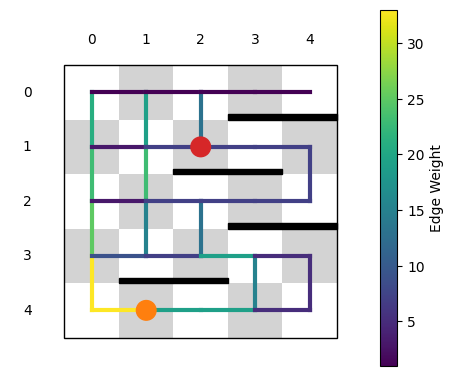

In [97]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import heapq

board_size = 5

pawn1_pos = (1, 2)
pawn2_pos = (4, 1)

fences = [
    (0, 3, 'v'),
    (0, 4, 'v'),
    (1, 2, 'v'),
    (1, 3, 'v'),
    (2, 3, 'v'),
    (2, 4, 'v'),
    (3, 1, 'v'),
    (3, 2, 'v'),


]

# Step 1: Build graph with weights
graph = defaultdict(list)

def set_edge_weight(a, b, new_weight):
    for i, (neighbor, weight) in enumerate(graph[a]):
        if neighbor == b:
            graph[a][i] = (b, new_weight)
    for i, (neighbor, weight) in enumerate(graph[b]):
        if neighbor == a:
            graph[b][i] = (a, new_weight)

def add_edge_weight(a, b, new_weight):
    for i, (neighbor, weight) in enumerate(graph[a]):
        if neighbor == b:
            graph[a][i] = (b, weight + new_weight)
    for i, (neighbor, weight) in enumerate(graph[b]):
        if neighbor == a:
            graph[b][i] = (a, weight + new_weight)


for row in range(board_size):
    for col in range(board_size):
        node = (row, col)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = row + dr, col + dc
            if 0 <= nr < board_size and 0 <= nc < board_size:
                neighbor = (nr, nc)
                weight = 1  # default weight
                graph[node].append((neighbor, weight))


def remove_edge(a, b):
    graph[a] = [(n, w) for n, w in graph[a] if n != b]
    graph[b] = [(n, w) for n, w in graph[b] if n != a]

for row, col, orientation in fences:
    if orientation == 'h':
        a = (row, col)
        b = (row, col + 1)
    elif orientation == 'v':
        a = (row, col)
        b = (row + 1, col)
    remove_edge(a, b)

# Step 2: Dijkstra's shortest path by weight
def dijkstra_path(start, target="bottom"):
    visited = {}
    heap = [(0, start, [])]  # (cost, current, path)
    
    while heap:
        cost, current, path = heapq.heappop(heap)
        if current[0] == (board_size - 1 if target == "top" else 0):  # Goal row
            return path + [current]
        if current in visited:
            continue
        visited[current] = cost
        for neighbor, weight in graph[current]:
            if neighbor not in visited:
                heapq.heappush(heap, (cost + weight, neighbor, path + [current]))
    return []



def add_weight_to_path_edges(path, delta):
    for i in range(len(path) - 1):
        a, b = path[i], path[i + 1]
        # Update a → b
        for j, (neighbor, weight) in enumerate(graph[a]):
            if neighbor == b:
                graph[a][j] = (b, weight + delta)
                break
        # Update b → a (since the graph is undirected)
        for j, (neighbor, weight) in enumerate(graph[b]):
            if neighbor == a:
                graph[b][j] = (a, weight + delta)
                break

for _ in range(25):
    path1 = dijkstra_path(pawn1_pos)
    path2 = dijkstra_path(pawn2_pos)

    add_weight_to_path_edges(path2, 2)

# Step 3: Draw board
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-1, board_size + 0.5)
ax.set_ylim(board_size + 0.5, -1)
ax.set_aspect('equal')
ax.axis('off')

# Draw squares
for row in range(board_size):
    for col in range(board_size):
        color = 'lightgrey' if (row + col) % 2 else 'white'
        rect = patches.Rectangle((col, row), 1, 1, facecolor=color)
        ax.add_patch(rect)

rect = patches.Rectangle((0, 0), board_size, board_size, linewidth=1,  edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Draw pawns
def draw_pawn(pos, color='black'):
    row, col = pos
    circ = patches.Circle((col + 0.5, row + 0.5), 0.18, color=color, zorder=10)
    ax.add_patch(circ)


# Draw fences
def draw_fence(row, col, orientation, color='black'):
    if orientation == 'v':
        # Fence between (row, col) and (row, col+1)
        x = col
        y = row + 0.9
        rect = patches.Rectangle((x, y), 1, 0.1, color=color)
    else:  # 'v'
        # Fence between (row, col) and (row+1, col)
        x = col + 0.9
        y = row
        rect = patches.Rectangle((x, y), 0.1, 1, color=color)
    ax.add_patch(rect)

for row, col, orientation in fences:
    draw_fence(row, col, orientation)

# Draw labels
for col in range(board_size):
    ax.text(col + 0.5, -0.6, str(col), ha='center', va='top', fontsize=10)
for row in range(board_size):
    ax.text(-0.6, row + 0.5, str(row), ha='right', va='center', fontsize=10)

# Draw paths
def draw_path(path, color):
    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i+1]
        ax.plot([c1 + 0.5, c2 + 0.5], [r1 + 0.5, r2 + 0.5], color=color, linewidth=2)

draw_pawn(pawn1_pos, color="tab:red")
draw_pawn(pawn2_pos, color="tab:orange")


# draw_path(path1, 'blue')
# draw_path(path2, 'green')

# # Draw weights on edges
# drawn_edges = set()
# for node in graph:
#     for neighbor, weight in graph[node]:
#         # Avoid drawing the same edge twice
#         edge = tuple(sorted([node, neighbor]))
#         if edge in drawn_edges:
#             continue
#         drawn_edges.add(edge)

#         r1, c1 = node
#         r2, c2 = neighbor
#         mid_x = (c1 + c2) / 2 + 0.1  # offset to avoid overlap
#         mid_y = (r1 + r2) / 2 + 0.1

#         ax.text(mid_x + 0.05, mid_y + 0.05, str(weight), fontsize=8, color='darkblue')


import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Step 1: Collect all weights
all_weights = [weight for node in graph for (neighbor, weight) in graph[node]]
min_w = min(all_weights)
max_w = max(all_weights)

# Step 2: Normalize and get colormap
norm = mcolors.Normalize(vmin=min_w, vmax=max_w)
cmap = cm.get_cmap('viridis')

# Step 3: Draw colored edges
drawn_edges = set()
for node in graph:
    for neighbor, weight in graph[node]:
        edge = tuple(sorted([node, neighbor]))
        if edge in drawn_edges:
            continue
        drawn_edges.add(edge)

        r1, c1 = node
        r2, c2 = neighbor
        color = cmap(norm(weight))
        ax.plot([c1 + 0.5, c2 + 0.5], [r1 + 0.5, r2 + 0.5], color=color, linewidth=3)

# Step 4: Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy data for the colorbar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Edge Weight')

plt.show()


In [86]:
graph_copy = graph

In [95]:
final_graph = {}

for start in graph:
    final_graph[start] = []
    for (dest1, weight1), (dest2, weight2) in zip(graph[start], graph_copy[start]):
        assert dest1 == dest2
        final_graph[start].append((dest1, weight1 - weight2))

/var/folders/mc/89gg5jrx4cb_27s7pckkcrg40000gn/T/ipykernel_5632/581087334.py:196: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


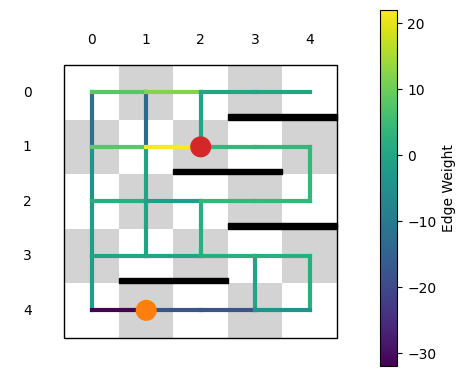

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import heapq

board_size = 5

pawn1_pos = (1, 2)
pawn2_pos = (4, 1)

fences = [
    (0, 3, 'v'),
    (0, 4, 'v'),
    (1, 2, 'v'),
    (1, 3, 'v'),
    (2, 3, 'v'),
    (2, 4, 'v'),
    (3, 1, 'v'),
    (3, 2, 'v'),


]

# Step 1: Build graph with weights
graph = defaultdict(list)

def set_edge_weight(a, b, new_weight):
    for i, (neighbor, weight) in enumerate(graph[a]):
        if neighbor == b:
            graph[a][i] = (b, new_weight)
    for i, (neighbor, weight) in enumerate(graph[b]):
        if neighbor == a:
            graph[b][i] = (a, new_weight)

def add_edge_weight(a, b, new_weight):
    for i, (neighbor, weight) in enumerate(graph[a]):
        if neighbor == b:
            graph[a][i] = (b, weight + new_weight)
    for i, (neighbor, weight) in enumerate(graph[b]):
        if neighbor == a:
            graph[b][i] = (a, weight + new_weight)


for row in range(board_size):
    for col in range(board_size):
        node = (row, col)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = row + dr, col + dc
            if 0 <= nr < board_size and 0 <= nc < board_size:
                neighbor = (nr, nc)
                weight = 1  # default weight
                graph[node].append((neighbor, weight))


def remove_edge(a, b):
    graph[a] = [(n, w) for n, w in graph[a] if n != b]
    graph[b] = [(n, w) for n, w in graph[b] if n != a]

for row, col, orientation in fences:
    if orientation == 'h':
        a = (row, col)
        b = (row, col + 1)
    elif orientation == 'v':
        a = (row, col)
        b = (row + 1, col)
    remove_edge(a, b)

# Step 2: Dijkstra's shortest path by weight
def dijkstra_path(start, target="top"):
    visited = {}
    heap = [(0, start, [])]  # (cost, current, path)
    
    while heap:
        cost, current, path = heapq.heappop(heap)
        if current[0] == (board_size - 1 if target == "top" else 0):  # Goal row
            return path + [current]
        if current in visited:
            continue
        visited[current] = cost
        for neighbor, weight in graph[current]:
            if neighbor not in visited:
                heapq.heappush(heap, (cost + weight, neighbor, path + [current]))
    return []



def add_weight_to_path_edges(path, delta):
    for i in range(len(path) - 1):
        a, b = path[i], path[i + 1]
        # Update a → b
        for j, (neighbor, weight) in enumerate(graph[a]):
            if neighbor == b:
                graph[a][j] = (b, weight + delta)
                break
        # Update b → a (since the graph is undirected)
        for j, (neighbor, weight) in enumerate(graph[b]):
            if neighbor == a:
                graph[b][j] = (a, weight + delta)
                break

for _ in range(25):
    path1 = dijkstra_path(pawn1_pos)
    path2 = dijkstra_path(pawn2_pos)

    add_weight_to_path_edges(path1, 2)

# Step 3: Draw board
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-1, board_size + 0.5)
ax.set_ylim(board_size + 0.5, -1)
ax.set_aspect('equal')
ax.axis('off')

# Draw squares
for row in range(board_size):
    for col in range(board_size):
        color = 'lightgrey' if (row + col) % 2 else 'white'
        rect = patches.Rectangle((col, row), 1, 1, facecolor=color)
        ax.add_patch(rect)

rect = patches.Rectangle((0, 0), board_size, board_size, linewidth=1,  edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Draw pawns
def draw_pawn(pos, color='black'):
    row, col = pos
    circ = patches.Circle((col + 0.5, row + 0.5), 0.18, color=color, zorder=10)
    ax.add_patch(circ)


# Draw fences
def draw_fence(row, col, orientation, color='black'):
    if orientation == 'v':
        # Fence between (row, col) and (row, col+1)
        x = col
        y = row + 0.9
        rect = patches.Rectangle((x, y), 1, 0.1, color=color)
    else:  # 'v'
        # Fence between (row, col) and (row+1, col)
        x = col + 0.9
        y = row
        rect = patches.Rectangle((x, y), 0.1, 1, color=color)
    ax.add_patch(rect)

for row, col, orientation in fences:
    draw_fence(row, col, orientation)

# Draw labels
for col in range(board_size):
    ax.text(col + 0.5, -0.6, str(col), ha='center', va='top', fontsize=10)
for row in range(board_size):
    ax.text(-0.6, row + 0.5, str(row), ha='right', va='center', fontsize=10)

# Draw paths
def draw_path(path, color):
    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i+1]
        ax.plot([c1 + 0.5, c2 + 0.5], [r1 + 0.5, r2 + 0.5], color=color, linewidth=2)

draw_pawn(pawn1_pos, color="tab:red")
draw_pawn(pawn2_pos, color="tab:orange")


# draw_path(path1, 'blue')
# draw_path(path2, 'green')

# # Draw weights on edges
# drawn_edges = set()
# for node in graph:
#     for neighbor, weight in graph[node]:
#         # Avoid drawing the same edge twice
#         edge = tuple(sorted([node, neighbor]))
#         if edge in drawn_edges:
#             continue
#         drawn_edges.add(edge)

#         r1, c1 = node
#         r2, c2 = neighbor
#         mid_x = (c1 + c2) / 2 + 0.1  # offset to avoid overlap
#         mid_y = (r1 + r2) / 2 + 0.1

#         ax.text(mid_x + 0.05, mid_y + 0.05, str(weight), fontsize=8, color='darkblue')


import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Step 1: Collect all weights
all_weights = [weight for node in final_graph for (neighbor, weight) in final_graph[node]]
min_w = min(all_weights)
max_w = max(all_weights)

# Step 2: Normalize and get colormap
norm = mcolors.Normalize(vmin=min_w, vmax=max_w)
cmap = cm.get_cmap('viridis')

# Step 3: Draw colored edges
drawn_edges = set()
for node in final_graph:
    for neighbor, weight in final_graph[node]:
        edge = tuple(sorted([node, neighbor]))
        if edge in drawn_edges:
            continue
        drawn_edges.add(edge)

        r1, c1 = node
        r2, c2 = neighbor
        color = cmap(norm(weight))
        ax.plot([c1 + 0.5, c2 + 0.5], [r1 + 0.5, r2 + 0.5], color=color, linewidth=3)

# Step 4: Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy data for the colorbar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Edge Weight')

plt.show()
